<a href="https://colab.research.google.com/github/JesperHLund/ML_mini_project/blob/main/CIFAR10_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN image classification using CIFAR10 small images classification dataset
We will train and evaluate a CNN on CIFAR10 small images classification dataset. It consists of 50,000 colour images of 32x32 pixels each, and 10,000 test images, labeled over 10 categories

## Setup

In [ ]:
# Common imports
import sys
import os
import sklearn
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

# To plot figures
%matplotlib inline
import matplotlib.pyplot as plt

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Load the data
Keras has a number of functions to load popular datasets in `keras.datasets`. The dataset is already split for you between a training set and a test set.

In [ ]:
cifar10_Images = keras.datasets.cifar10
(X_train_full, y_train_full), (X_test, y_test) = cifar10_Images.load_data()
assert X_train_full.shape == (50000, 32, 32, 3)
assert X_test.shape == (10000, 32, 32, 3)
assert y_train_full.shape == (50000, 1)
assert y_test.shape == (10000, 1)

#One hot encoding, as dataset contains 10 classes which are represented as unique integers
y_train_full = to_categorical(y_train_full)
y_test = to_categorical(y_test)

##Data augmentation to help prevent overfitting

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255.,
    shear_range=0.2,        # Adding a shear_range so that images can be processed from different perspectives
    zoom_range=0.2,         # Zoom in by max 20%
    horizontal_flip=True,   # Flip images horizontally at random
)


##Pixel preparation

In [ ]:
#Converting integers to floats
X_train_full = X_train_full.astype('float32')
X_test = X_test.astype('float32')

#normalizing to range between 0 and 1
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0

##split in validation and training set

In [ ]:
# Split the full training set into a validation set and a (smaller) training set,
# and scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]



In [ ]:
train_data = ImageDataGenerator(
        rescale=1./255, # Change pixel value from 0-255 to 0.0 - 1.0 This applies Feature Scaling to every image, by dividing the pixel values by 255
        shear_range=0.2, # Adding a shear_range so that images can be processed from different perspectives
        zoom_range=0.2, # How far to randomly zoom in/out of an image
        horizontal_flip=True) # This will randomly flip our input images horizontally.

#applies data augmentation to training set
training_set = train_data.flow(X_train_full,y_train_full)

In [ ]:
test_data = ImageDataGenerator(rescale=1./255)
##Applies rescaling to test set
test_set = test_data.flow(X_test,y_test)

In [ ]:
X_train.shape

(45000, 32, 32, 3)

In [ ]:
y_train.shape

(45000, 10)

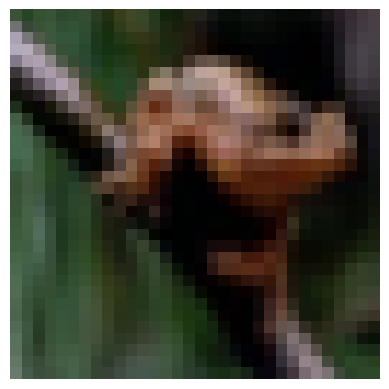

In [ ]:
# #Plot an image using Matplotlib's imshow() function, with a binary color map:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

In [ ]:
# The labels are the class IDs (represented as uint8), from 0 to 9.
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
# Load class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
# class_names[y_train[0][0]]

## Create a CNN model using the Sequential

In [ ]:
#Creating the model and makes the padding the same for each layer.
#Best result on test set, at lower filters was 60%, 64% with higher filters
model = keras.models.Sequential([
   keras.layers.Conv2D(filters=32, kernel_size=7, activation='relu', padding="SAME",
                       input_shape=[32, 32, 3]),
   keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding="SAME"),
   keras.layers.MaxPooling2D(pool_size=2),
  #  keras.layers.Dropout(0.2),
   keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding="SAME"),
   keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding="SAME"),
   keras.layers.MaxPooling2D(pool_size=2),
  #  keras.layers.Dropout(0.2),
   keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding="SAME"),
   keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding="SAME"),
   keras.layers.MaxPooling2D(pool_size=2),
   keras.layers.Flatten(),
   keras.layers.Dense(units=128, activation='relu'),
   keras.layers.Dropout(0.5),
   keras.layers.Dense(units=10, activation='softmax'),
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        4736      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                   

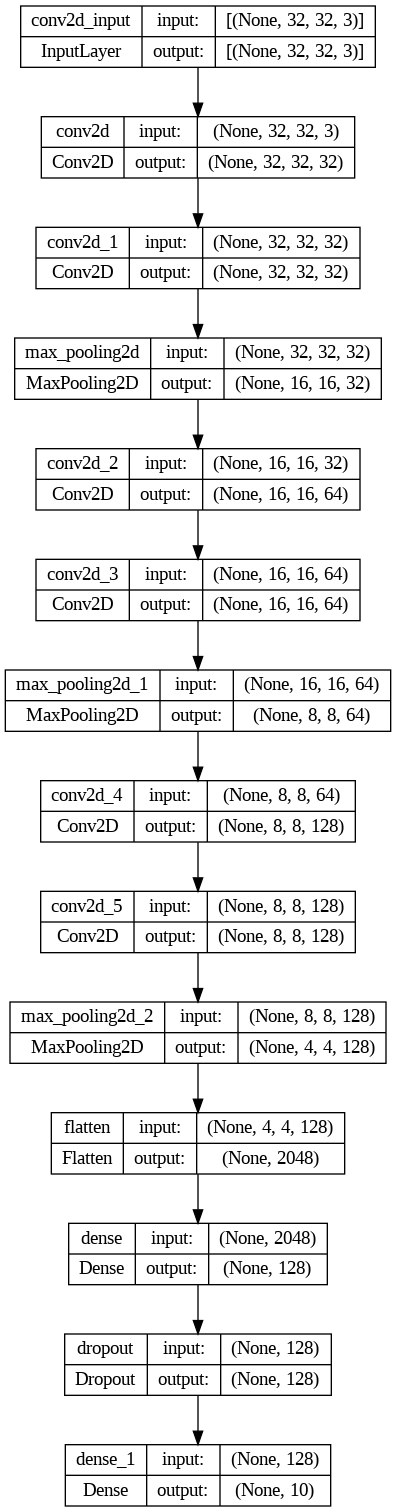

In [ ]:
keras.utils.plot_model(model,show_shapes=True)


## Compile the model

In [ ]:
# model.compile(loss="sparse_categorical_crossentropy",
#               optimizer='adam',
#               metrics=["accuracy"])

model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
              metrics=["accuracy"])

# model.compile(loss="sparse_categorical_crossentropy",
#              optimizer=keras.optimizers.SGD(learning_rate=0.001,momentum=0.9),
#              metrics=["accuracy"])

##Training the model

In [ ]:
# # EarlyStopping (with rollback to the best model).
early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# # Performance scheduling
# # (multiply the learning rate by a factor when the error stops dropping for a number of epochs, called patience)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=4)

history = model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=[early_stopping, lr_scheduler])
# history2 = model.fit(training_set, epochs=300, validation_data=test_set, callbacks=[early_stopping])

Epoch 1/300
1407/1407 [==============================] - 20s 8ms/step - loss: 2.1480 - accuracy: 0.1985 - val_loss: 1.8754 - val_accuracy: 0.3108 - lr: 0.0010
Epoch 2/300
1407/1407 [==============================] - 10s 7ms/step - loss: 1.8122 - accuracy: 0.3399 - val_loss: 1.5843 - val_accuracy: 0.4286 - lr: 0.0010
Epoch 3/300
1407/1407 [==============================] - 10s 7ms/step - loss: 1.6405 - accuracy: 0.4053 - val_loss: 1.4577 - val_accuracy: 0.4770 - lr: 0.0010
Epoch 4/300
1407/1407 [==============================] - 10s 7ms/step - loss: 1.5337 - accuracy: 0.4484 - val_loss: 1.3812 - val_accuracy: 0.5034 - lr: 0.0010
Epoch 5/300
1407/1407 [==============================] - 10s 7ms/step - loss: 1.4557 - accuracy: 0.4746 - val_loss: 1.3518 - val_accuracy: 0.5242 - lr: 0.0010
Epoch 6/300
1407/1407 [==============================] - 11s 8ms/step - loss: 1.3847 - accuracy: 0.5017 - val_loss: 1.2665 - val_accuracy: 0.5490 - lr: 0.0010
Epoch 7/300
1407/1407 [=======================

### Evaluate

In [ ]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 5ms/step - loss: 0.8733 - accuracy: 0.7107


[0.873282253742218, 0.7106999754905701]